In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import math
import seaborn as sns
import statsmodels.api as sm
import sklearn.metrics
import graphviz

from collections import Counter
from scipy.stats import sigmaclip
from sklearn import tree
from scipy import stats
from scipy.stats import sigmaclip as sg
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, StackingClassifier, GradientBoostingClassifier, RandomForestClassifier

In [169]:
train = pd.read_csv('data/train.csv').drop('id', axis=1)
test = pd.read_csv('data/test.csv').drop('id', axis=1)

In [170]:
print(f"Количество NaN в train: {train.isna().sum().sum()}")
print(f"Количество NaN в test: {test.isna().sum().sum()}")

Количество NaN в train: 0
Количество NaN в test: 0


In [171]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,48,1,35.0,1,1-2 Year,No,24922.0,26.0,86,0
1,Male,58,1,28.0,0,1-2 Year,Yes,63541.0,26.0,57,0
2,Male,44,1,28.0,1,1-2 Year,No,30027.0,26.0,286,0
3,Female,22,1,8.0,0,< 1 Year,Yes,35039.0,152.0,180,0
4,Male,24,1,6.0,1,< 1 Year,No,24149.0,152.0,17,0


In [172]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                229292 non-null  object 
 1   Age                   229292 non-null  int64  
 2   Driving_License       229292 non-null  int64  
 3   Region_Code           229292 non-null  float64
 4   Previously_Insured    229292 non-null  int64  
 5   Vehicle_Age           229292 non-null  object 
 6   Vehicle_Damage        229292 non-null  object 
 7   Annual_Premium        229292 non-null  float64
 8   Policy_Sales_Channel  229292 non-null  float64
 9   Vintage               229292 non-null  int64  
 10  Response              229292 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 19.2+ MB


In [173]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152862 entries, 0 to 152861
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                152862 non-null  object 
 1   Age                   152862 non-null  int64  
 2   Driving_License       152862 non-null  int64  
 3   Region_Code           152862 non-null  float64
 4   Previously_Insured    152862 non-null  int64  
 5   Vehicle_Age           152862 non-null  object 
 6   Vehicle_Damage        152862 non-null  object 
 7   Annual_Premium        152862 non-null  float64
 8   Policy_Sales_Channel  152862 non-null  float64
 9   Vintage               152862 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 11.7+ MB


In [174]:
numerical_columns = [
    'Age',
    'Driving_License',
    'Region_Code',
    'Annual_Premium',
    'Policy_Sales_Channel',
    'Vintage'
]
categorial_columns = [
    'Gender',
    'Vehicle_Age',
    'Vehicle_Damage'
]
target_column = ['Response']

In [175]:
cols = numerical_columns + categorial_columns

## Обработка данных

In [176]:
for i in categorial_columns:
    print(f'{i} - {train[i].unique()}')

Gender - ['Male' 'Female']
Vehicle_Age - ['1-2 Year' '< 1 Year' '> 2 Years']
Vehicle_Damage - ['No' 'Yes']


In [177]:
def process_data(data, categorial_columns, numerical_columns):
    """
    Функция обработки данных 
    
    :param data: Dataframe на обработку
    :type data: DataFrame
    :param cat_cols: Категориальные признаки
    :type cat_cols: list
    :param num_cols: Числовые признаки
    :type num_cols: list
    :return: Обработанный Dataframe
    :rtype: DataFrame
    """
    scaler = StandardScaler()
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    data[categorial_columns] = data[categorial_columns].apply(LabelEncoder().fit_transform)
    return data

In [178]:
train = process_data(train, categorial_columns, numerical_columns)
test = process_data(test, categorial_columns, numerical_columns)

In [179]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0.620092,0.043194,0.650406,1,0,0,-0.340557,-1.582151,-0.814487,0
1,1,1.276621,0.043194,0.119759,0,0,1,1.923870,-1.582151,-1.160851,0
2,1,0.357481,0.043194,0.119759,1,0,0,-0.041225,-1.582151,1.574233,0
3,0,-1.086883,0.043194,-1.396375,0,1,1,0.252654,0.737943,0.308211,0
4,1,-0.955577,0.043194,-1.547989,1,1,0,-0.385882,0.737943,-1.638595,0


In [180]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                229292 non-null  int32  
 1   Age                   229292 non-null  float64
 2   Driving_License       229292 non-null  float64
 3   Region_Code           229292 non-null  float64
 4   Previously_Insured    229292 non-null  int64  
 5   Vehicle_Age           229292 non-null  int32  
 6   Vehicle_Damage        229292 non-null  int32  
 7   Annual_Premium        229292 non-null  float64
 8   Policy_Sales_Channel  229292 non-null  float64
 9   Vintage               229292 non-null  float64
 10  Response              229292 non-null  int64  
dtypes: float64(6), int32(3), int64(2)
memory usage: 16.6 MB


In [181]:
def sigma_drop(df, columns):
    """
    Функция удаления выбросов
    
    :param df: Dataframe на обработку
    :type df: DataFrame
    :param columns: Столбцы
    :type df: list
    :return: None
    :rtype: None
    """
    for column in columns:
        _, low, up = sigmaclip(df[column].dropna(), 2, 2)
        df.drop(df.index[(df[column] > up) | (df[column] < low)], inplace=True)

In [182]:
sigma_drop(train, cols)
sigma_drop(test, cols)

In [183]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
3,0,-1.086883,0.043194,-1.396375,0,1,1,0.252654,0.737943,0.308211,0
4,1,-0.955577,0.043194,-1.547989,1,1,0,-0.385882,0.737943,-1.638595,0
5,0,0.685745,0.043194,0.119759,0,0,1,-1.647649,0.830011,0.021565,0
6,1,-0.692965,0.043194,-1.547989,1,1,0,0.024857,0.737943,-0.050097,0
7,1,-1.086883,0.043194,-1.093148,1,1,0,-0.162658,0.737943,0.236550,0


In [184]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,-1.020500,0.044047,1.109928,1,1,0,-0.208885,0.737938,-0.897725
2,1,0.556399,0.044047,0.122525,1,0,1,0.579193,0.221845,1.323245
3,1,-1.020500,0.044047,1.109928,1,1,0,-0.154292,0.737938,0.857558
6,1,-1.151908,0.044047,-1.396557,1,1,0,0.041234,0.885393,0.188879
7,0,-0.889092,0.044047,0.122525,0,1,1,0.679885,0.221845,0.045590


## Дерево решений

In [185]:
x = train[cols]
y = train[target_column]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

In [186]:
def get_model_scores(model, x_train, y_train, return_estimator=False):
    """
    Эта функция оценивает модель на основе перекрестной проверки и тестовых данных
    
    :param model: Модель для подсчета score
    :type model: estimator
    :return: Точность обучения, точность тестирования
    :rtype: list
    """
    results = cross_validate(model, x_train, y_train, scoring='roc_auc', return_estimator=True)
    cv = np.mean(results['test_score'])
    model = results["estimator"][results['test_score'].argmax()]
    test = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    if return_estimator:
        return cv, test, model
    return cv, test

In [187]:
def comparison_plot(first_score, second_score, title='Comparison between two models'):
    """
    Функция сравнения score моделей
    
    :param first_score: Score первой модели
    :type first_score: float
    :param second_score: Score следующей модели
    :type second_score: float
    :return: None
    :rtype: None
    """
    plt.figure(figsize=(4, 4))
    sns.barplot(x=['Without parameters', 'With parameters'],y=[first_score, second_score])
    margin = 0.05
    plt.ylim(first_score - margin, second_score + margin)
    plt.ylabel("ROC-AUC accuracy")
    plt.title(title)
    plt.show()

In [188]:
def tree_plot(parameters, crossval_scores, predict_scores, p_type, width=10, height=3):
    """
    :param parameters: Список параметров для визуализации
    :type parameters: range
    :param crossval_scores: Список scores
    :type crossval_scores: list
    :param predict_scores: Список predict scores
    :type predict_scores: list
    :param p_type: Тип графика
    :type p_type: str
    :return: None
    :rtype: None
    """
    plt.figure(figsize=(width, height))
    plt.plot(parameters, crossval_scores, label='Cvl score')
    plt.plot(parameters, predict_scores, label='Test score')
    cv_max = np.argmax(crossval_scores)
    plt.plot(parameters[cv_max], crossval_scores[cv_max], 'go', label='Max')
    cv_min = np.argmin(crossval_scores)
    plt.plot(parameters[cv_min], crossval_scores[cv_min], 'ro', label='Min')
    test_max = np.argmax(predict_scores)
    plt.plot(parameters[test_max], predict_scores[test_max], 'go')
    test_min = np.argmin(predict_scores)
    plt.plot(parameters[test_min], predict_scores[test_min], 'ro')
    plt.xlabel(p_type)
    plt.ylabel("ROC-AUC accuracy")
    plt.xticks(parameters)
    plt.title(f'Scores for {p_type} parameters')
    plt.legend()
    plt.show()

In [189]:
clf = DecisionTreeClassifier()
train_score, default_tree_score, clf = get_model_scores(clf, x_train, y_train, return_estimator=True)
print("Точность сырой модели - ", round(default_tree_score, 4))

Точность сырой модели -  0.6711


In [190]:
dot_data = tree.export_graphviz(clf, out_file="clftree.dot", 
                     feature_names=cols,  
                     class_names=['0', '1'],  
                     filled=True, rounded=True,  
                     special_characters=True)

In [191]:
cv_scores = []
test_scores = []
max_depth = range(3, 25)
for value in max_depth:
    clf = DecisionTreeClassifier(max_depth=value)
    cv, test = get_model_scores(clf, x_train, y_train)
    cv_scores.append(cv)
    test_scores.append(test)

best_max_depth = max_depth[np.argmax(test_scores)]

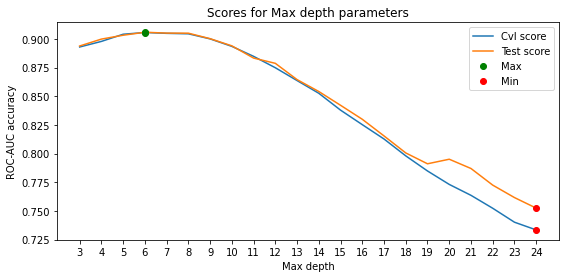

In [192]:
tree_plot(max_depth, cv_scores, test_scores, 'Max depth', width=9, height=4)

In [193]:
cv_scores = []
test_scores = []
min_samples_split = range(3, 30)
for value in min_samples_split:
    clf = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=value)
    cv, test = get_model_scores(clf, x_train, y_train)
    cv_scores.append(cv)
    test_scores.append(test)
best_min_samples_split = min_samples_split[np.argmax(test_scores)]

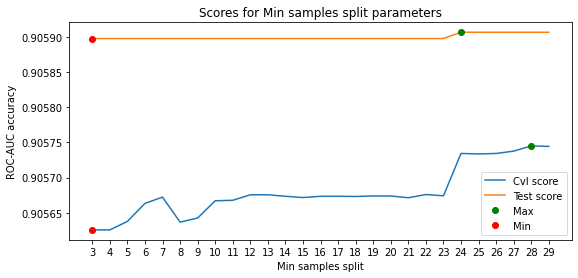

In [194]:
tree_plot(min_samples_split, cv_scores, test_scores, 'Min samples split', width=9, height=4)

In [195]:
cv_scores = []
test_scores = []
max_features = range(3, len(cols))
for value in max_features:
    clf = DecisionTreeClassifier(max_depth=best_max_depth,
                                 min_samples_split=best_min_samples_split,
                                 max_features=value)
    cv, test = get_model_scores(clf, x_train, y_train)
    cv_scores.append(cv)
    test_scores.append(test)
best_max_features = max_features[np.argmax(test_scores)]

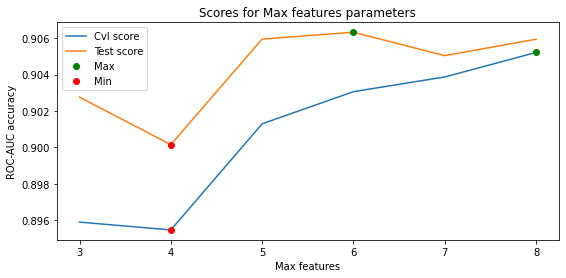

In [196]:
tree_plot(max_features, cv_scores, test_scores, 'Max features', width=9, height=4)

In [197]:
clf = DecisionTreeClassifier(max_features=best_max_features,
                             max_depth=best_max_depth,
                             min_samples_split=best_min_samples_split)
train_score, optimal_tree_score, clf = get_model_scores(clf, x_train, y_train, return_estimator=True)
print("Точность модели с подобранными вручную параметрами - ", round(optimal_tree_score,4))

Точность модели с подобранными вручную параметрами -  0.9037


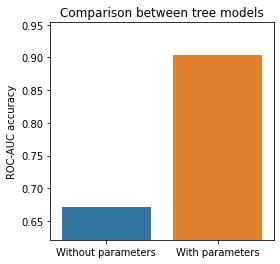

In [198]:
comparison_plot(default_tree_score, optimal_tree_score, title='Comparison between tree models')

## Ансамбли моделей

### Бэггинг

In [199]:
bg = BaggingClassifier()
train_score, default_bg_score, bg = get_model_scores(bg, x_train, y_train, return_estimator=True)
print("Точность классификатора бэггинга с ненастроенными параметрами - ", default_bg_score)

Точность классификатора бэггинга с ненастроенными параметрами -  0.8695746150383311


In [201]:
cv_scores = []
test_scores = []
estimators = range(10, 20)
for value in estimators:
    bg = BaggingClassifier(n_estimators=value)
    cv, test = get_model_scores(bg, x_train, y_train)
    cv_scores.append(cv)
    test_scores.append(test)
best_estimators_count = estimators[np.argmax(test_scores)]

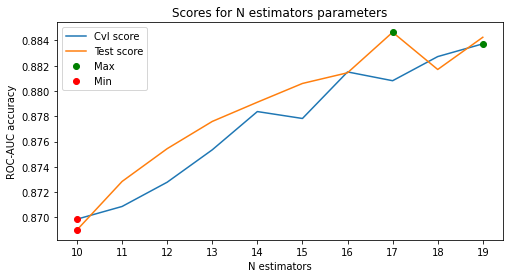

In [202]:
tree_plot(estimators, cv_scores, test_scores, 'N estimators', width=8, height=4)

In [203]:
cv_scores = []
test_scores = []
max_features = range(2, len(cols))
for value in max_features:
    bg = BaggingClassifier(n_estimators=best_estimators_count, max_features=value)
    cv, test = get_model_scores(bg, x_train, y_train)
    cv_scores.append(cv)
    test_scores.append(test)
best_bg_features = max_features[np.argmax(test_scores)]

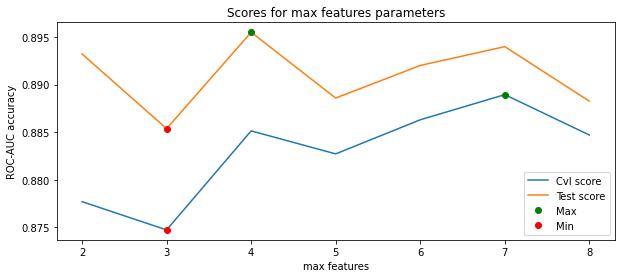

In [204]:
tree_plot(max_features, cv_scores, test_scores, 'max features', width=10, height=4)

In [205]:
bg = BaggingClassifier(max_features=best_bg_features,
                       n_estimators=best_estimators_count)
train_score, optimal_bg_score, bg = get_model_scores(bg, x_train, y_train, return_estimator=True)
print("Точность модели с подобранными вручную параметрами - ", round(optimal_bg_score,4))

Точность модели с подобранными вручную параметрами -  0.891


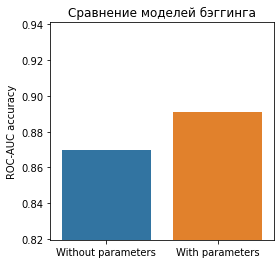

In [225]:
comparison_plot(default_bg_score, optimal_bg_score, title='Сравнение моделей бэггинга')

### Бустинг

In [207]:
gb = GradientBoostingClassifier()
train_score, default_gb_score, gb = get_model_scores(gb, x_train, y_train, return_estimator=True)
print("Точность классификатора градиентного бустинга с ненастроенными параметрами - ", default_gb_score)

Точность классификатора градиентного бустинга с ненастроенными параметрами -  0.9109598121346884


In [209]:
cv_scores = []
test_scores = []
learning_rates = [0.1, 0.25, 0.5, 0.75, 1]
for rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate=rate)
    cv, test = get_model_scores(gb, x_train, y_train)
    cv_scores.append(cv)
    test_scores.append(test)
best_learning_rate = learning_rates[np.argmax(test_scores)]

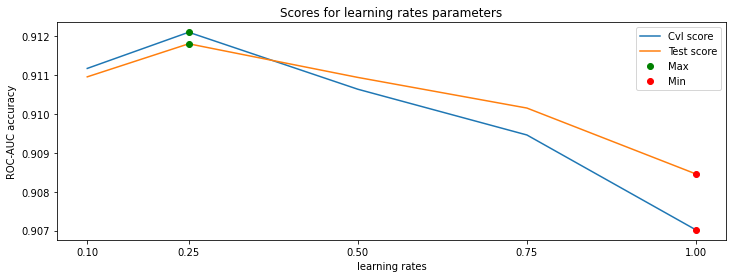

In [210]:
tree_plot(learning_rates, cv_scores, test_scores, 'learning rates', width=12, height=4)

In [211]:
cv_scores = []
test_scores = []
estimators = range(40, 70)
for value in estimators:
    gb = GradientBoostingClassifier(learning_rate=best_learning_rate, n_estimators=value)
    cv, test = get_model_scores(gb, x_train, y_train)
    cv_scores.append(cv)
    test_scores.append(test)
best_estimators_count = estimators[np.argmax(test_scores)]

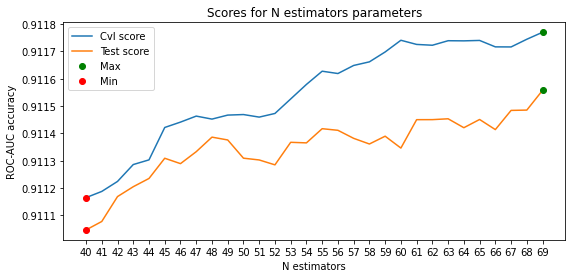

In [212]:
tree_plot(estimators, cv_scores, test_scores, 'N estimators', width=9, height=4)

In [213]:
cv_scores = []
test_scores = []
max_features = range(2, len(cols))
for value in max_features:
    gb = GradientBoostingClassifier(learning_rate=best_learning_rate,
                                    n_estimators=best_estimators_count,
                                    max_features=value)
    cv, test = get_model_scores(gb, x_train, y_train)
    cv_scores.append(cv)
    test_scores.append(test)
best_max_features = max_features[np.argmax(test_scores)]

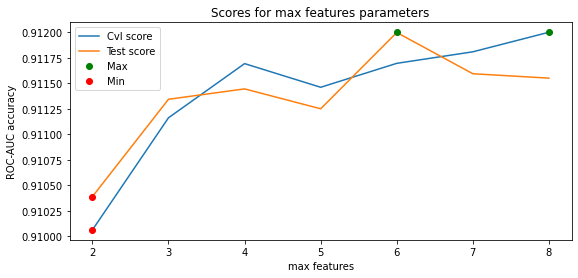

In [214]:
tree_plot(max_features, cv_scores, test_scores, 'max features', width=9, height=4)

In [215]:
gb = GradientBoostingClassifier(learning_rate=best_learning_rate,
                                    n_estimators=best_estimators_count,
                                    max_features=best_max_features).fit(x_train, y_train)
train_score, optimal_gb_score, gb = get_model_scores(gb, x_train, y_train, return_estimator=True)
print("Точность модели с подобранными вручную параметрами - ", round(optimal_gb_score,4))

Точность модели с подобранными вручную параметрами -  0.9117


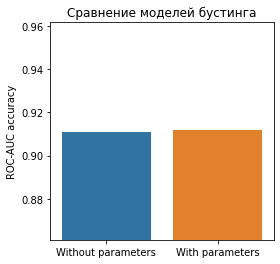

In [226]:
comparison_plot(default_gb_score, optimal_gb_score, title='Сравнение моделей бустинга')

### Стекинг

In [217]:
estimators = [('reg', LogisticRegression())]
stk = StackingClassifier(estimators)
train_score, default_stk_score, stk = get_model_scores(stk,x_train, y_train, return_estimator=True)
print("Точность стекинга с одной логистической регрессией - ", round(default_stk_score, 4))

Точность стекинга с одной логистической регрессией -  0.8902


In [218]:
reg = LogisticRegression()
knn = KNeighborsClassifier()
rfc = RandomForestClassifier()
dtc = clf
options = [
    [('reg', reg), ('knn', knn)],
    [('reg', reg), ('rfc', rfc)],
    [('reg', reg), ('knn', knn), ('rfc', rfc)],
    [('reg', reg), ('knn', knn), ('rfc', rfc), ('dtc', dtc)],
    [('gb', gb), ('dtc', dtc)],
    [('reg', reg), ('gb', gb)],
    [('reg', reg), ('gb', gb), ('dtc', dtc)]
]

In [219]:
cv_scores = []
test_scores = []
for stack in options:
    stk = StackingClassifier(stack, stack_method='predict_proba')
    cv, test = get_model_scores(stk, x_train, y_train)
    cv_scores.append(cv)
    test_scores.append(test)

In [220]:
best_stack = options[np.argmax(test_scores)]
optimal_stacking_score = max(test_scores)
print(f"Лучший стек моделей - {[model[1] for model in best_stack]} с точностью {round(optimal_stacking_score, 4)}")

Лучший стек моделей - [GradientBoostingClassifier(learning_rate=0.25, max_features=6, n_estimators=69), DecisionTreeClassifier(max_depth=6, max_features=6, min_samples_split=24)] с точностью 0.9116


## Сравнение результатов

In [221]:
reg = LogisticRegression(penalty='l2', C=1.0)
train_score, optimal_reg_score, reg = get_model_scores(reg, x_train, y_train, return_estimator=True)
print("Точность модели из второй практической работы - ", optimal_reg_score)

Точность модели из второй практической работы -  0.8902143832684462


In [222]:
models = ['Decision tree', 
          'Logistic regression', 
          'Baggging classifier', 
          'Gradient boosting', 
          'Stacking classifier']
scores = [optimal_tree_score, 
          optimal_reg_score, 
          optimal_bg_score, 
          optimal_gb_score, 
          optimal_stacking_score]

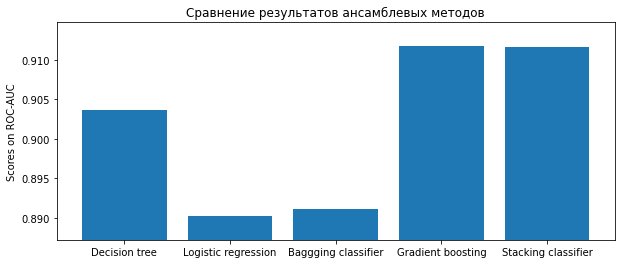

In [227]:
plt.figure(figsize=(10, 4))
plt.bar(models, scores)
plt.ylabel('Scores on ROC-AUC')
margin = 0.003
plt.ylim(min(scores) - margin, max(scores) + margin)
plt.title("Сравнение результатов ансамблевых методов")
plt.show()

In [224]:
print(f"{models[np.argmax(scores)]} показал наилучший результат: {round(max(scores), 3)}")

Gradient boosting показал наилучший результат: 0.912
